非可聴での測位


In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import get_spectrum_amplitude
from positioning.sound_db import SoundDB
from positioning import tools

In [3]:
sns.set(context="poster", style="whitegrid")

In [4]:
res_dir = "../../result/non-audible/15-21k"
os.makedirs(res_dir, exist_ok=True)

In [5]:
db = SoundDB(
    "../data/reference_non-audible_2d",
    first_freq=15000,
    last_freq=22000,
    interval=0.2,
    dim=2,
)

In [6]:
true_pos = pd.read_csv(
    "../data/pos2d-non-audible_20230920/true_positions.csv", index_col=0
)

In [7]:
est_poses = []
est_polars = []
errors = []
for i in range(20):
    test_signal = readwav(f"../data/pos2d-non-audible_20230920/test{i}.wav")
    err = []
    pos = []
    polar = []
    for j in range(100):
        est_polar = np.ravel(
            db.positioning(test_signal[j * 96000 : (j + 2) * 96000], output="polar")
        )
        est_pos = tools.polar_to_rect(est_polar[1], np.radians(est_polar[0]))
        pos.append(est_pos)
        polar.append(est_polar)
        err.append(np.linalg.norm(est_pos - true_pos.iloc[i]))
    est_poses.append(pos)
    est_polars.append(polar)
    errors.append(err)

In [8]:
df_est = pd.DataFrame()
for i in range(20):
    df_est_pos = pd.DataFrame(est_poses[i], columns=["x", "y"])
    df_est_pos["azimuth"] = np.array(est_polars[i])[:, 0]
    df_est_pos["distance"] = np.array(est_polars[i])[:, 1]
    df_est_pos["error"] = errors[i]
    df_est_pos["test_position"] = f"test{i}"
    df_est = pd.concat([df_est, df_est_pos])
df_est.reset_index(inplace=True, drop=True)

In [9]:
df_est.head()

,x,y,azimuth,distance,error,test_position
0,-0.632096,0.870006,-36.0,1.075387,0.043930,test0
1,-0.632096,0.870006,-36.0,1.075387,0.043930,test0
2,-0.627974,0.896840,-35.0,1.094839,0.028152,test0
3,-0.627974,0.896840,-35.0,1.094839,0.028152,test0
4,-0.629388,0.866279,-36.0,1.070780,0.044730,test0


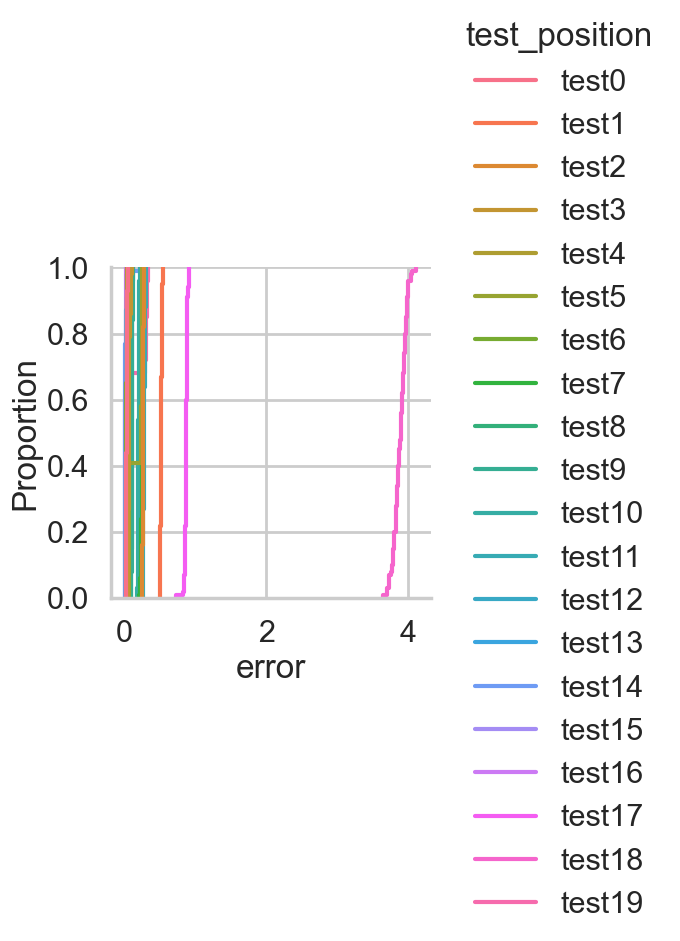

In [10]:
sns.displot(df_est, x="error", hue="test_position", kind="ecdf")
plt.savefig(f"{res_dir}/pos_error_cdf.png", bbox_inches="tight")

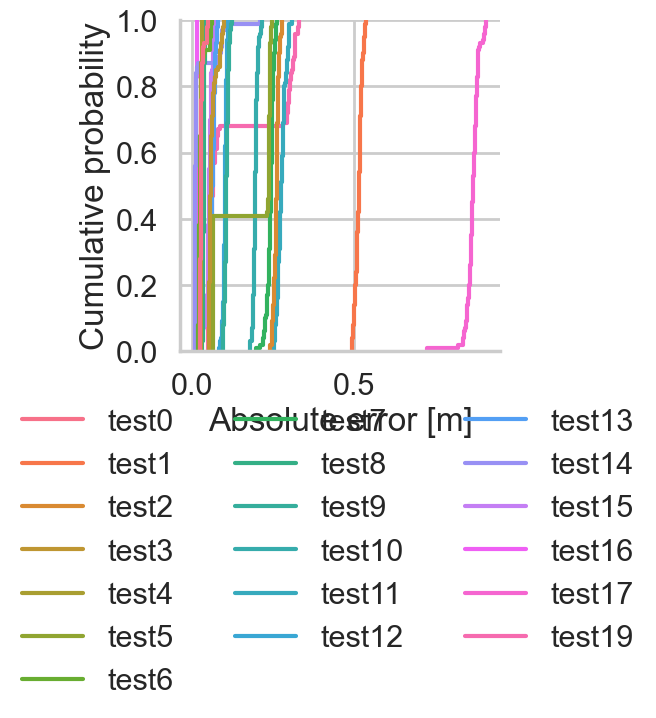

In [11]:
ax = sns.displot(
    df_est[df_est["test_position"] != "test18"],
    x="error",
    hue="test_position",
    kind="ecdf",
)
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.4, -0.5), ncol=3, title=None, frameon=False
)
plt.xlabel("Absolute error [m]")
plt.ylabel("Cumulative probability")
plt.savefig(f"{res_dir}/pos_cdf_no_test18.png", bbox_inches="tight")

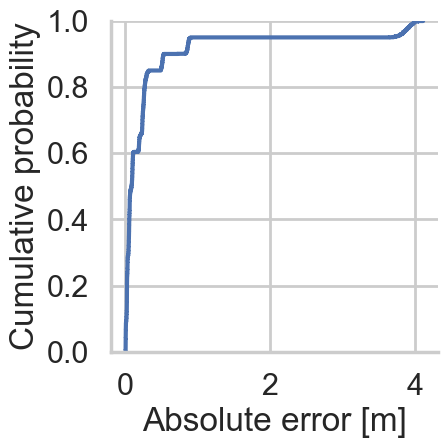

In [12]:
sns.displot(df_est, x="error", kind="ecdf")
plt.xlabel("Absolute error [m]")
plt.ylabel("Cumulative probability")
plt.savefig(f"{res_dir}/pos_error_cdf_all.svg", bbox_inches="tight")

In [13]:
df_positions = df_est[["x", "y", "test_position"]]
df_positions.loc[:, "true_or_test"] = "test"
true_pos["test_position"] = true_pos.index
true_pos["true_or_test"] = "true"
df_positions = pd.concat([df_positions, true_pos])
df_positions.reset_index(drop=True, inplace=True)
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              2020 non-null   float64
 1   y              2020 non-null   float64
 2   test_position  2020 non-null   object 
 3   true_or_test   2020 non-null   object 
dtypes: float64(2), object(2)
memory usage: 63.3+ KB


/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_14047/2238469347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions.loc[:, "true_or_test"] = "test"


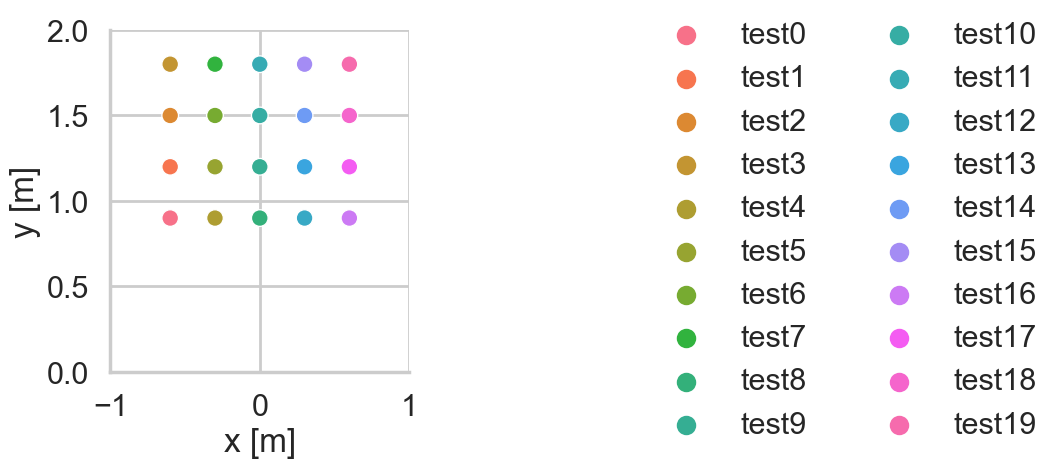

In [14]:
ax = sns.relplot(
    df_positions[df_positions["true_or_test"] == "true"],
    x="x",
    y="y",
    hue="test_position",
)
sns.move_legend(
    ax, "upper left", ncol=2, bbox_to_anchor=(1, 1), title=None, frameon=False
)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(-1, 1)
plt.ylim(0, 2)
plt.savefig(f"{res_dir}/true_pos.svg", bbox_inches="tight")

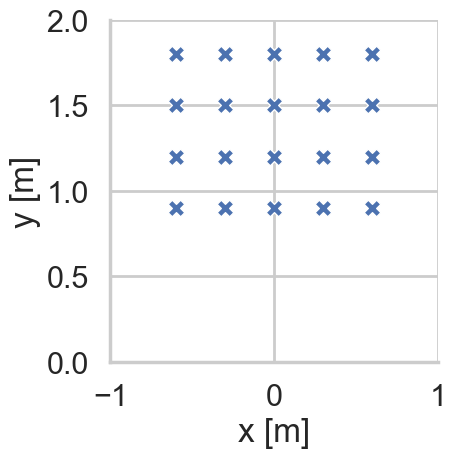

In [15]:
sns.relplot(
    df_positions[df_positions["true_or_test"] == "true"], x="x", y="y", marker="X"
)
plt.xlim(-1, 1)
plt.ylim(0, 2)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.savefig(f"{res_dir}/true_pos_poster.svg")

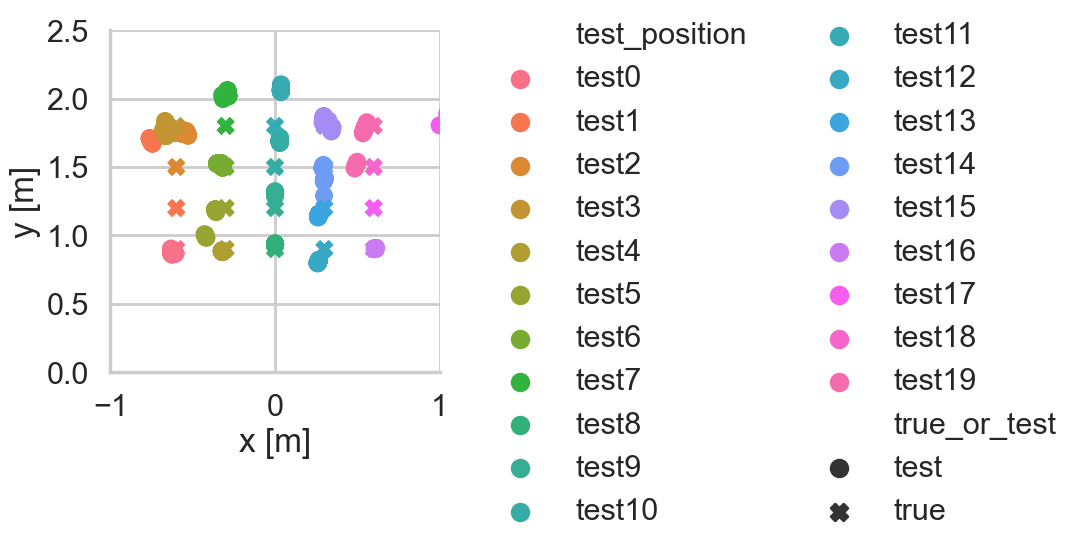

In [16]:
ax = sns.relplot(
    df_positions,
    x="x",
    y="y",
    hue="test_position",
    style="true_or_test",
    ec="face",
)
sns.move_legend(
    ax, "upper left", bbox_to_anchor=(0.7, 1), ncol=2, title=None, frameon=False
)
plt.xlim(-1, 1)
plt.ylim(0, 2.5)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.savefig(f"{res_dir}/positioning.svg", bbox_inches="tight")

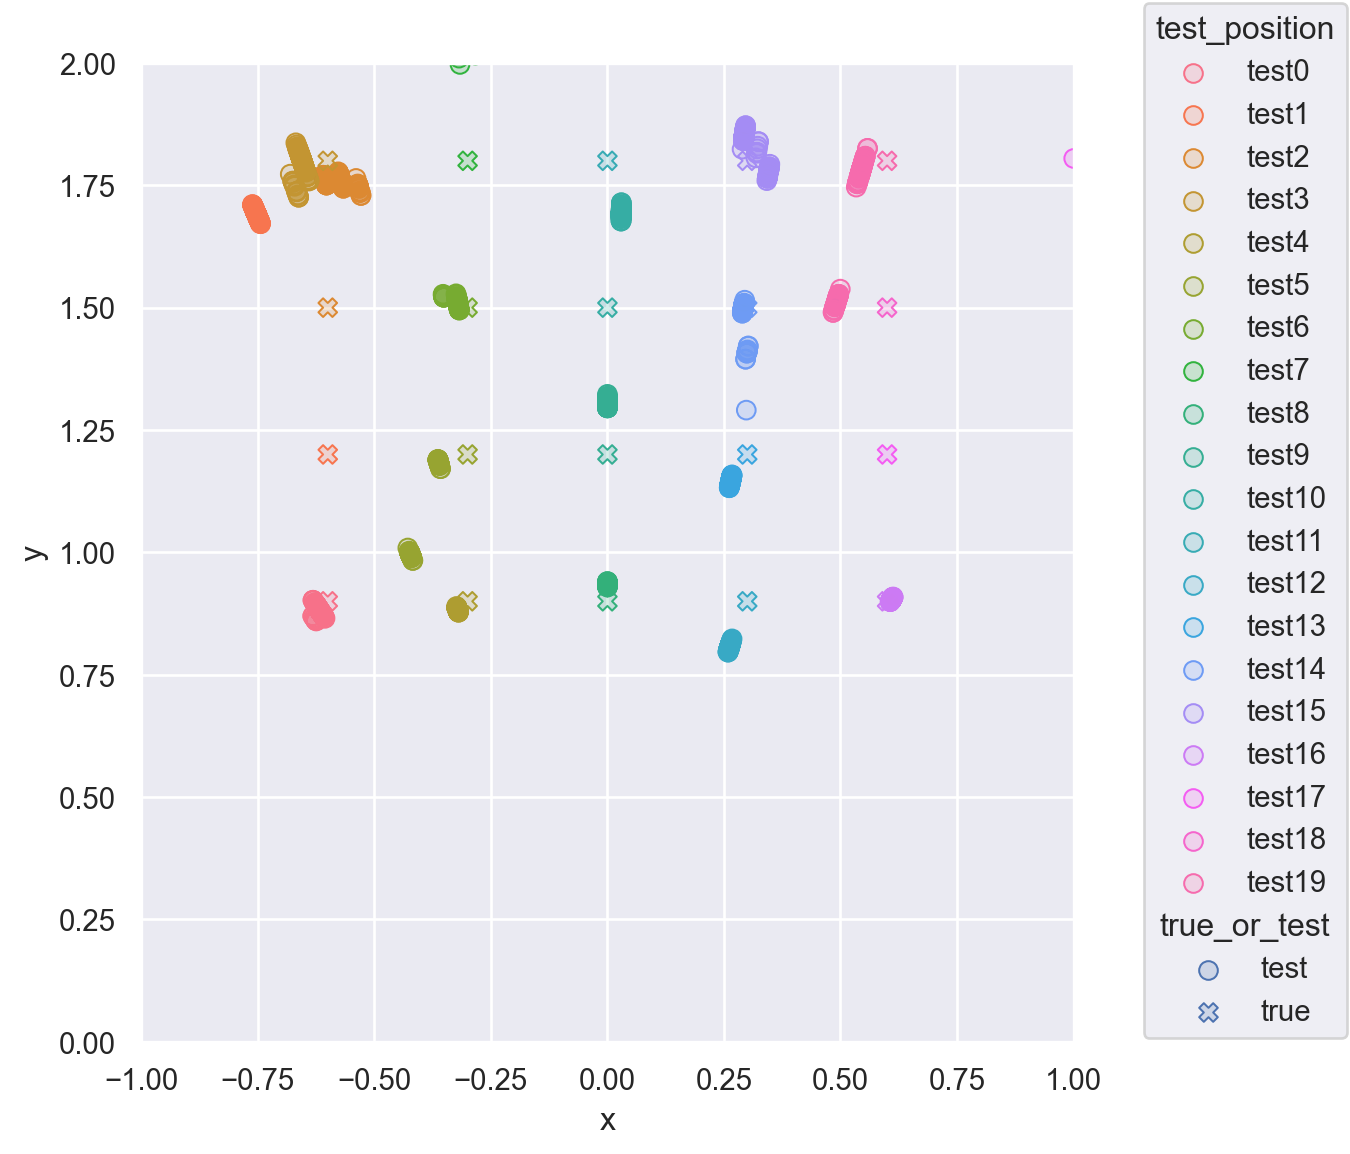

In [17]:
(
    so.Plot(df_positions, x="x", y="y", color="test_position", marker="true_or_test")
    .add(so.Dots(pointsize=7))
    .limit(x=(-1, 1), y=(0, 2))
    .layout(size=(6, 6))
)

In [18]:
fiftyth_p = []
ninetyth_p = []
test_points = df_est["test_position"].unique()
for p in test_points:
    fiftyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 50))
    ninetyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 90))
df_cdf = pd.DataFrame(
    {"test_position": test_points, "50th": fiftyth_p, "90th": ninetyth_p}
)
df_cdf.head(20)

,test_position,50th,90th
0,test0,0.026017,0.031824
1,test1,0.515756,0.526689
2,test2,0.260360,0.269388
3,test3,0.056346,0.085966
4,test4,0.026777,0.028551
5,test5,0.236345,0.240993
6,test6,0.023512,0.035778
7,test7,0.242718,0.253834
8,test8,0.034667,0.037730
9,test9,0.105304,0.112880


In [19]:
print(np.percentile(df_est["error"], 90))

0.5546693312539481


In [20]:
true_distance, true_azimuth = tools.rect_to_polar(true_pos["x"], true_pos["y"])
true_pos["distance"] = true_distance
true_pos["azimuth"] = true_azimuth
true_pos.head()

,x,y,test_position,true_or_test,distance,azimuth
test0,-0.6,0.9,test0,true,1.081665,-33.690068
test1,-0.6,1.2,test1,true,1.341641,-26.565051
test2,-0.6,1.5,test2,true,1.615549,-21.801409
test3,-0.6,1.8,test3,true,1.897367,-18.434949
test4,-0.3,0.9,test4,true,0.948683,-18.434949


In [21]:
df_polar = df_est[["distance", "azimuth", "test_position"]]
df_polar.loc[:, "true_or_test"] = "test"
df_polar = pd.concat(
    [
        df_polar,
        true_pos[["distance", "azimuth", "test_position", "true_or_test"]],
    ]
)
df_polar.reset_index(drop=True, inplace=True)
df_polar.head()
true_pos.rename(columns={"azimuth": "true_azimuth"}, inplace=True)
df_polar = pd.merge(
    df_polar, true_pos[["test_position", "true_azimuth"]], on="test_position"
)
df_polar["azimuth_error"] = np.abs(df_polar["azimuth"] - df_polar["true_azimuth"])
df_polar.head()

/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_14047/2744435699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polar.loc[:, "true_or_test"] = "test"


,distance,azimuth,test_position,true_or_test,true_azimuth,azimuth_error
0,1.075387,-36.0,test0,test,-33.690068,2.309932
1,1.075387,-36.0,test0,test,-33.690068,2.309932
2,1.094839,-35.0,test0,test,-33.690068,1.309932
3,1.094839,-35.0,test0,test,-33.690068,1.309932
4,1.070780,-36.0,test0,test,-33.690068,2.309932


In [22]:
print(np.percentile(df_polar["azimuth_error"], 90))

3.1985905136481882


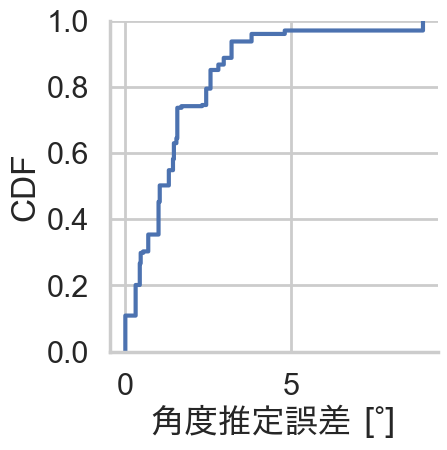

In [23]:
sns.set("poster", "whitegrid")
sns.displot(df_polar, x="azimuth_error", kind="ecdf")
plt.xlabel("角度推定誤差 [°]", fontname="Hiragino Sans")
plt.ylabel("CDF")
plt.savefig(f"{res_dir}/azimuth_error_cdf_all.svg", bbox_inches="tight")

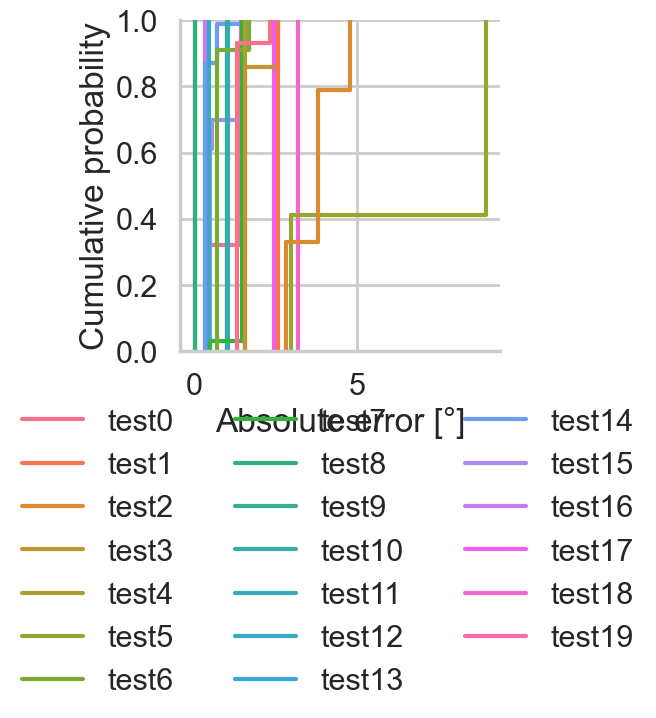

In [24]:
ax = sns.displot(
    df_polar[df_polar["true_or_test"] == "test"],
    x="azimuth_error",
    hue="test_position",
    kind="ecdf",
)
# sns.move_legend(
#     ax, "upper center", ncol=4, bbox_to_anchor=(0.5, 0), title=None, frameon=False
# )
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.4, -0.5), ncol=3, title=None, frameon=False
)
plt.xlabel("Absolute error [°]")
plt.ylabel("Cumulative probability")
plt.savefig(f"{res_dir}/azimuth_error_cdf.png", bbox_inches="tight")

In [25]:
signal18 = readwav("../data/pos2d-non-audible_20230920/test18.wav")
spec18 = []
ampli18 = []
for i in range(100):
    spec, ampli = get_spectrum_amplitude(
        signal18[i * 96000 : (i + 2) * 96000],
        first_freq=15000,
        last_freq=24000,
        interval_length=0.2,
    )
    spec18.append(spec)
    ampli18.append(ampli)

In [26]:
signal19 = readwav("../data/pos2d-non-audible_20230920/test19.wav")
spec19 = []
ampli19 = []
for i in range(100):
    spec, ampli = get_spectrum_amplitude(
        signal19[i * 96000 : (i + 2) * 96000],
        first_freq=15000,
        last_freq=24000,
        interval_length=0.2,
    )
    spec19.append(spec)
    ampli19.append(ampli)

In [27]:
signal17 = readwav("../data/pos2d-non-audible_20230920/test17.wav")
spec17 = []
ampli17 = []
for i in range(100):
    spec, ampli = get_spectrum_amplitude(
        signal17[i * 96000 : (i + 2) * 96000],
        first_freq=15000,
        last_freq=24000,
        interval_length=0.2,
    )
    spec17.append(spec)
    ampli17.append(ampli)

In [28]:
signal16 = readwav("../data/pos2d-non-audible_20230920/test16.wav")
spec16 = []
ampli16 = []
for i in range(100):
    spec, ampli = get_spectrum_amplitude(
        signal16[i * 96000 : (i + 2) * 96000],
        first_freq=15000,
        last_freq=24000,
        interval_length=0.2,
    )
    spec16.append(spec)
    ampli16.append(ampli)

In [29]:
ampli_avg = []
for i in range(16, 20):
    ampli_avg.append(np.mean(eval(f"ampli{i}"), axis=0))

In [30]:
print(ampli_avg)

[200354.38738443606, 88715.2366119044, 30502.66092159691, 99349.09897032997]


In [31]:
true_dist_side = true_distance[16:20]
print(true_dist_side)

test16    1.081665
test17    1.341641
test18    1.615549
test19    1.897367
dtype: float64


In [32]:
ideal_ampli = ampli_avg[0] * true_dist_side[0] / true_dist_side
print(ideal_ampli)

test16    200354.387384
test17    161530.871210
test18    134144.087108
test19    114219.574403
dtype: float64


In [33]:
df_side_ampli = pd.DataFrame(ideal_ampli, columns=["ideal"])

In [34]:
df_side_ampli

,ideal
test16,200354.387384
test17,161530.871210
test18,134144.087108
test19,114219.574403


In [35]:
df_side_ampli["real"] = ampli_avg

In [36]:
df_side_ampli

,ideal,real
test16,200354.387384,200354.387384
test17,161530.871210,88715.236612
test18,134144.087108,30502.660922
test19,114219.574403,99349.098970


In [37]:
df_side_ampli["distance"] = true_dist_side

In [38]:
df_side_ampli

,ideal,real,distance
test16,200354.387384,200354.387384,1.081665
test17,161530.871210,88715.236612,1.341641
test18,134144.087108,30502.660922,1.615549
test19,114219.574403,99349.098970,1.897367


In [39]:
print(df_side_ampli.stack())

test16  ideal       200354.387384
        real        200354.387384
        distance         1.081665
test17  ideal       161530.871210
        real         88715.236612
        distance         1.341641
test18  ideal       134144.087108
        real         30502.660922
        distance         1.615549
test19  ideal       114219.574403
        real         99349.098970
        distance         1.897367
dtype: float64


In [40]:
df_side_ampli_long = df_side_ampli.melt(
    id_vars=["distance"], var_name="type", value_name="Amplitude"
)
df_side_ampli_long

,distance,type,Amplitude
0,1.081665,ideal,200354.387384
1,1.341641,ideal,161530.871210
2,1.615549,ideal,134144.087108
3,1.897367,ideal,114219.574403
4,1.081665,real,200354.387384
5,1.341641,real,88715.236612
6,1.615549,real,30502.660922
7,1.897367,real,99349.098970


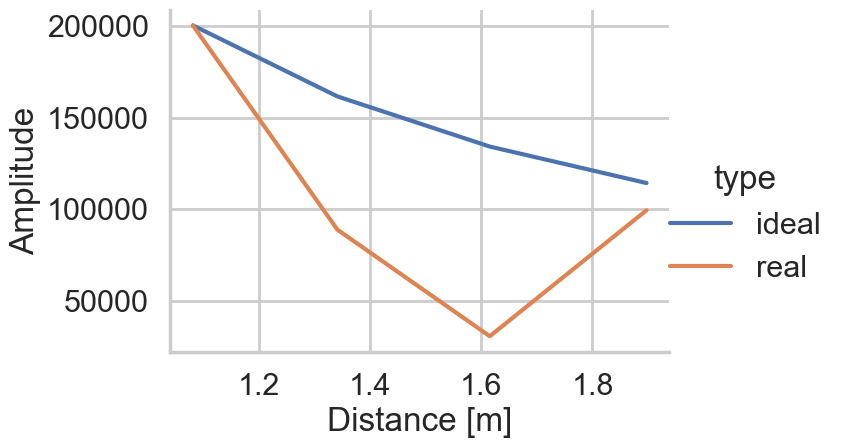

In [41]:
ax = sns.relplot(
    df_side_ampli_long,
    x="distance",
    y="Amplitude",
    kind="line",
    hue="type",
    height=5,
    aspect=1.5,
)
plt.xlabel("Distance [m]")
plt.ylabel("Amplitude")
plt.savefig(f"{res_dir}/amplitude_valley.svg", bbox_inches="tight")

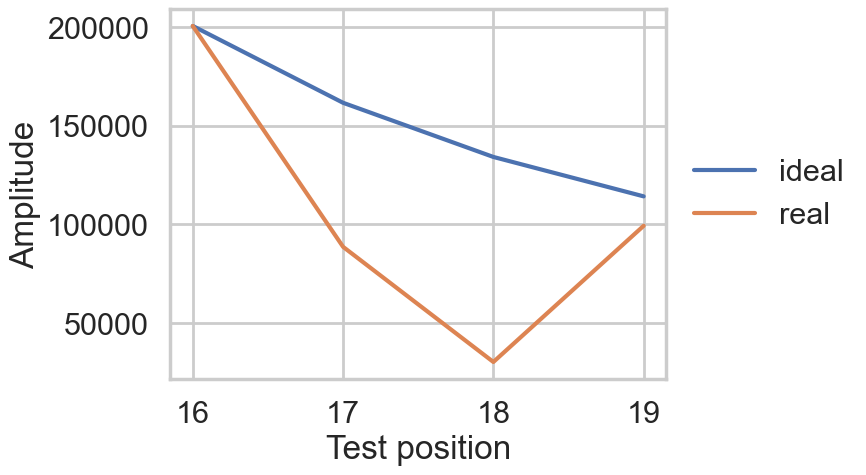

In [42]:
plt.plot(range(16, 20), df_side_ampli["ideal"], label="ideal")
plt.plot(range(16, 20), df_side_ampli["real"], label="real")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlabel("Test position")
plt.ylabel("Amplitude")
plt.savefig(f"{res_dir}/amplitude_gap.svg", bbox_inches="tight")

In [43]:
true_pos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, test0 to test19
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              20 non-null     float64
 1   y              20 non-null     float64
 2   test_position  20 non-null     object 
 3   true_or_test   20 non-null     object 
 4   distance       20 non-null     float64
 5   true_azimuth   20 non-null     float64
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [44]:
t_azimuth = true_pos["true_azimuth"].to_numpy()

In [45]:
print(t_azimuth)

[-33.69006753 -26.56505118 -21.80140949 -18.43494882 -18.43494882
 -14.03624347 -11.30993247  -9.46232221   0.           0.
   0.           0.          18.43494882  14.03624347  11.30993247
   9.46232221  33.69006753  26.56505118  21.80140949  18.43494882]


In [46]:
t_azimuth = np.round(t_azimuth, decimals=0)
print(t_azimuth)

[-34. -27. -22. -18. -18. -14. -11.  -9.   0.   0.   0.   0.  18.  14.
  11.   9.  34.  27.  22.  18.]


In [47]:
t_azimuth = t_azimuth.astype(int)
print(t_azimuth)

[-34 -27 -22 -18 -18 -14 -11  -9   0   0   0   0  18  14  11   9  34  27
  22  18]


In [48]:
est_distances = []
distance_errors = []
for i in range(20):
    test_signal = readwav(f"../data/pos2d-non-audible_20230920/test{i}.wav")
    dist = []
    err = []
    for j in range(100):
        est_dist = db.estimate_distance(
            test_signal[j * 96000 : (j + 2) * 96000], t_azimuth[i] + 40
        )
        dist_err = np.abs(est_dist - true_pos.iloc[i]["distance"])
        dist.append(est_dist)
        err.append(dist_err)
    est_distances.append(dist)
    distance_errors.append(err)

In [49]:
df_distances = pd.DataFrame()
for i in range(20):
    df_dist = pd.DataFrame(est_distances[i], columns=["distance"])
    df_dist["error"] = distance_errors[i]
    df_dist["test_position"] = f"test{i}"
    df_distances = pd.concat([df_distances, df_dist])
df_distances.reset_index(inplace=True, drop=True)
df_distances.head()

,distance,error,test_position
0,1.174511,[0.09284584974452503],test0
1,1.174511,[0.09284584974452503],test0
2,1.152517,[0.07085175914019781],test0
3,1.152517,[0.07085175914019781],test0
4,1.169479,[0.0878139316317319],test0


In [50]:
df_distances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       2000 non-null   float64
 1   error          2000 non-null   object 
 2   test_position  2000 non-null   object 
dtypes: float64(1), object(2)
memory usage: 47.0+ KB


In [51]:
df_distances["error"].describe()

count                      2000
unique                     1400
top       [0.09284584974452503]
freq                          2
Name: error, dtype: object

In [52]:
df_distances["error"] = df_distances["error"].astype(float)

In [53]:
df_distances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       2000 non-null   float64
 1   error          2000 non-null   float64
 2   test_position  2000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 47.0+ KB


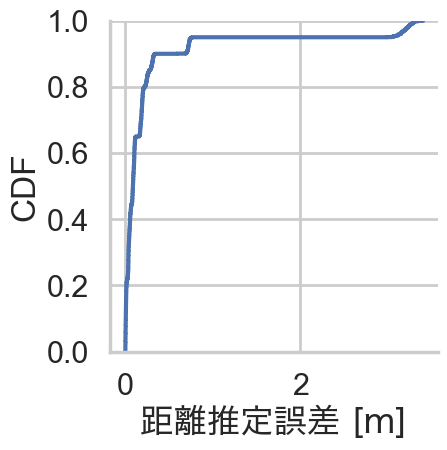

In [54]:
sns.displot(df_distances, x="error", kind="ecdf")
plt.xlabel("距離推定誤差 [m]", fontname="Hiragino Sans")
plt.ylabel("CDF")
plt.savefig(f"{res_dir}/distance_error_cdf.svg", bbox_inches="tight")

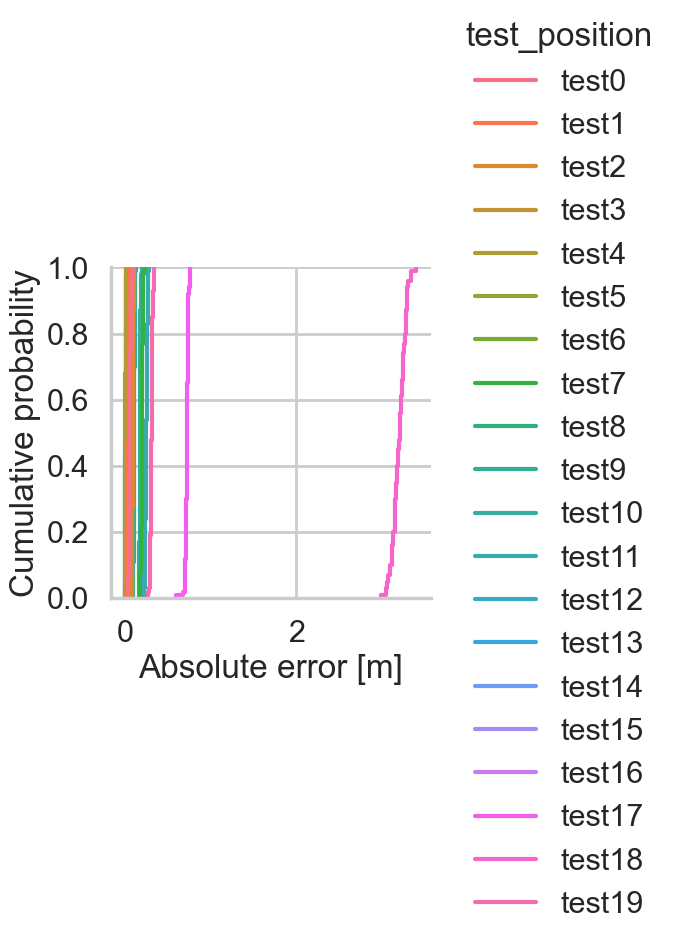

In [55]:
sns.displot(df_distances, x="error", kind="ecdf", hue="test_position")
plt.xlabel("Absolute error [m]")
plt.ylabel("Cumulative probability")
plt.savefig(f"{res_dir}/distance_error_pt_cdf.svg", bbox_inches="tight")

In [56]:
df_distances["error"].describe()

count    2000.000000
mean        0.282418
std         0.688523
min         0.000022
25%         0.033042
50%         0.086736
75%         0.192054
max         3.399315
Name: error, dtype: float64

In [57]:
print(np.percentile(df_distances["error"], 90))

0.365979277132901


In [58]:
true_pos.head(20)

,x,y,test_position,true_or_test,distance,true_azimuth
test0,-0.6,0.9,test0,true,1.081665,-33.690068
test1,-0.6,1.2,test1,true,1.341641,-26.565051
test2,-0.6,1.5,test2,true,1.615549,-21.801409
test3,-0.6,1.8,test3,true,1.897367,-18.434949
test4,-0.3,0.9,test4,true,0.948683,-18.434949
test5,-0.3,1.2,test5,true,1.236932,-14.036243
test6,-0.3,1.5,test6,true,1.529706,-11.309932
test7,-0.3,1.8,test7,true,1.824829,-9.462322
test8,0.0,0.9,test8,true,0.900000,0.000000
test9,0.0,1.2,test9,true,1.200000,0.000000
